In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
import glob
import os
import peakutils
import datetime
import warnings
import logging
from jupyterthemes import jtplot

In [77]:
from xps.xps_sw import *
from xps.xps_import import *
from xps.xps_analysis import *
from xps.xps_bg import *

jtplot.style('default', grid=False)
logging.getLogger().setLevel(logging.CRITICAL)

plt.rcParams['errorbar.capsize'] = 8
plt.rcParams['font.size'] = 18
plt.rc('font', size= 18)
plt.rc('legend', fontsize= 15)
plt.rc('xtick', labelsize= 18)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', size=6)

plt.rc('ytick', labelsize= 18)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)

In [5]:
asf = dict({'C_1s' : 0.296, 'O_1s' : 0.711, 'N_1s' : 0.477, 'Ba_3d' : 7.49,
            'Cu_2p' : 5.321, 'Cl_2p' : 0.891})

In [6]:
def plot_regions(experiments : list, regions : list, colors : list = None):
    """Subplots all regions of a list of experiments (unnormalised)"""
    rows = int(np.ceil(len(regions) / 3))
    cols = 3
    
    fig, ax = plt.subplots(rows, cols, figsize=(16, 8))
    for i,r in enumerate(regions):
        for c,xp in enumerate(experiments):
            j, k = i//3, i%3            
            if i == len(regions) - 1:   # Set labels from last region
                li = plot_region(xp, r, ax=ax[j][k], lb=xp.name)
                if len(colors) > 0: li.set_color(colors[c])
                ax[j][k].set_title('Au_4f')
                ax[j][k].get_legend().remove()
            else:
                li = plot_region(xp, r, ax=ax[j][k], lb='__nolabel__')
                if len(colors) > 0: li.set_color(colors[c])
                ax[j][k].set_title(r)
            cosmetics_plot(ax=ax[j][k], leg = False);
        if len(experiments)%2 == 0:
            ax[j][k].invert_xaxis()
    plt.tight_layout()
    fig.legend()

### Background subtraction class (dev) 

In [5]:
class Background2(object):
    @staticmethod
    def bg_handler(xp, region,  *args, **kwargs):
        x = xp.dfx[region].dropna().energy.values
        y = xp.dfx[region].dropna().counts.values
        return x, y

    @staticmethod
    def edit_xp(xp, region, x, y, ybg, ax = None):
        if ax == None: ax = plt.gca()
        col = plot_region(xp, region, lb=region, ax=ax).get_color()
        ax.plot(x, ybg, '--', color=col, label='__nolabel__')
        cosmetics_plot(ax=ax)
        
        dfnew = pd.DataFrame({'energy' : x, 'counts' : y - ybg})
        xpNew = deepcopy(xp)
        xpNew.dfx[region] = dfnew
        return xpNew

    def dec_linear(self, xp, region, *args, **kwargs):
        x, y = self.bg_handler(xp, region, *args, **kwargs)

        ybg = peakutils.baseline(y, deg=1)
        return self.edit_xp(xp, region, x, y, ybg)
    
    def dec_shirley(self, xp, region, maxit=40, **kwargs):
        kwargs['maxit'] = maxit
        x,y = self.bg_handler(xp, region, **kwargs)
        ybg = shirley_loop(x,y, **kwargs)
        return self.edit_xp(xp, region, x, y, ybg)
    
    def dec_2shirley(self, xp, region, xlim, maxit=40, **kwargs):
        x, y = self.bg_handler(xp, region, **kwargs)
        y1 = y[ x >= xlim ]
        x1 = x[ x >= xlim ]
        y2 = y[ x <= xlim ]
        x2 = x[ x <= xlim ]

        ybg1 = shirley_loop(x1, y1, maxit = maxit)#, flag_plot=flag_plot, ax = ax)
        ybg2 = shirley_loop(x2, y2, maxit = maxit)#, flag_plot=flag_plot, ax = ax)
        ybg = np.append(np.append(ybg1[:-1], np.average([ybg1[-1], ybg2[0]])), ybg2[1:] )
        return self.edit_xp(xp, region, x, y, ybg, **kwargs)

NameError: name 'trim_exps' is not defined

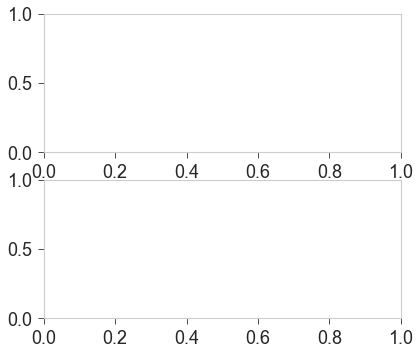

In [6]:
# Background2().dec_linear(xp=experiments[0], region='C_1s')
fig, ax = plt.subplots(2)
BG2 = Background2()
bg2 = BG2.dec_2shirley(xp=trim_exps[0], region='overview_', 
                       xlim = 346, maxit=50, ax=ax[0])
bg2 = BG2.dec_linear(xp=trim_exps[0], 
                     region='overview_', ax=ax[1])

In [ ]:
def test_bg_subpots()
    fig, ax = plt.subplots(2)
    BG2 = Background2()
    bg2 = BG2.dec_2shirley(xp=trim_exps[0], region='overview_', 
                           xlim = 346, maxit=50, ax=ax[0])
    bglin = BG2.dec_linear(xp=trim_exps[0], 
                         region='overview_', ax=ax[1])

    assert len(ax[0].get_lines()) <= 2, "Too many lines in lin_bg subplot"
    assert len(ax[0].get_lines()) >= 2, "Not enough lines in lin_bg subplot"

In [ ]:
BG2 = Background2()
bg2 = BG2.dec_2shirley(xp=trim_exps[0], region='overview_', 
                       xlim = 346, maxit=50, ax=ax[0])
x,y = BG2.bg_handler(xp=trim_exps[0], region='overview_')
x,ybg = BG2.bg_handler(bg2, region='overview_')
lentest = len(np.where(y < ybg)[0])
assert lentest == 0, "Background over signal in %i points"%lentest


In [ ]:
BG2 = Background2()
bg2 = BG2.dec_linear(xp=trim_exps[0], region='overview_')
x,y = BG2.bg_handler(xp=trim_exps[0], region='overview_')
x,ybg = BG2.bg_handler(bg2, region='overview_')
lentest = len(np.where(y < ybg)[0])
assert lentest == 0, "Background over signal in %i points"%lentest


In [ ]:
def test_method(method):
    BG2 = Background2()
    bg2 = method(xp=trim_exps[0], region='overview_')
    x,y = BG2.bg_handler(xp=trim_exps[0], region='overview_')
    x,ybg = BG2.bg_handler(bg2, region='overview_')
    lentest = len(np.where(y < ybg)[0])
    assert lentest == 0, "Background over signal in %i points"%lentest
test_method(Background2().dec_linear)

## Pre-processing of data BaCl$_2$ and Ba(ClO$_4$)$_2$ on Cu policrystal
1- Sublimations of Ba(ClO$_4$)$_2$ (10th Aug 2020)

2- Sublimations of BaCl$_2$ (26th October 2020)

Each set contain Clean Cu data, BaCl* sublimation data and FBI deposition _after_ Ba (ALInjected FBI-ester on AcN in the 1st case and sublimated in the 2nd)

## Import data

In [78]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/Cu_BaCl2/**/*.xy'
files = glob.glob(path, recursive=True)
files.sort()
files_new = []
for f in files:
    if (' ' not in f) and ('/proc' not in f):
        files_new.append(f)

filesCl2 = files_new
filesCl2.pop(1)  # This experiment failed, no BaCl was sublimeated
for f in filesCl2:
    print(f)

/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/Cu_BaCl2/20201022_Cu_clean.xy
/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/Cu_BaCl2/20201026_Cu_BaCl2_subl_45min.xy
/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/Cu_BaCl2/20201026_Cu_BaCl2_subl_45min_FBI_subl_20min.xy
/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/Cu_BaCl2/20201027_Cu_BaCl2_subl_45min_FBI_subl_40min.xy


In [79]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/Cu_BaClO42/**/*.xy'
files = glob.glob(path, recursive=True)
files.sort()
files_new = []
for f in files:
    if (' ' not in f) and ('/proc' not in f):
        files_new.append(f)

filesClO4 = files_new
filesClO4[0], filesClO4[2] = filesClO4[2], filesClO4[0]
filesClO4[1], filesClO4[2] = filesClO4[2], filesClO4[1]

for f in filesClO4:
    print(f)

/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/Cu_BaClO42/20200810_Cu_clean1.xy
/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/Cu_BaClO42/20200810_Cu_BaClO42_sublim_15min.xy
/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/Cu_BaClO42/20200810_Cu_BaClO42_sublim_1h.xy
/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/Cu_BaClO42/20200811_Cu_BaClO42_sublim_2h15min.xy
/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/Cu_BaClO42/20200811_Cu_BaClO42_sublim_3h45min.xy
/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/Cu_BaClO42/20200813_Cu_BaClO42_sublim_3h45min_FBI_ester_200pulses.xy


In [80]:
expsCl2 = [xps_data_import(path=f) for f in filesCl2]
expsCl2[3].name

'Cu_BaCl2_subl_45min_FBI_subl_40min'

In [81]:
expsClO4 = [xps_data_import(path=f) for f in filesClO4]
expsClO4[3].name

'Cu_BaClO42_sublim_2h15min'

## BG subtraction

In [26]:
region = 'Cu_2p'

Text(0.5, 1.0, 'Cu 2p')

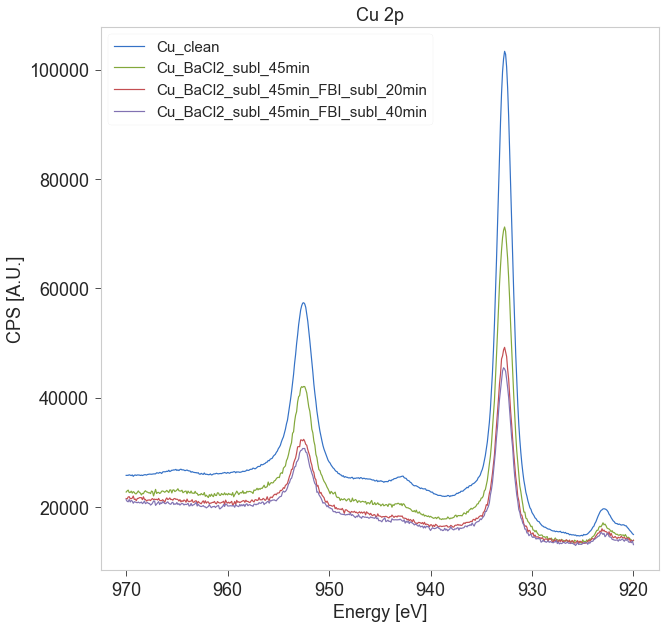

In [27]:
plt.figure(figsize=(10,10))
for xp in expsCl2:
    try:
        plot_region(xp, region)
    except KeyError:
        print('Keyeror on', xp.name)
        
# plt.xlim(70, 100)
# plt.ylim(1.5e5, 4e5)
cosmetics_plot()
plt.title('Cu 2p')

/Users/pabloherrero/sabat/sabatsw/xps/xps_analysis.py:66: RuntimeWarning: invalid value encountered in greater
  dropup = np.where(xp.dfx[region].energy.values > eup)[0]


Text(0.5, 1.0, 'Cu 2p')

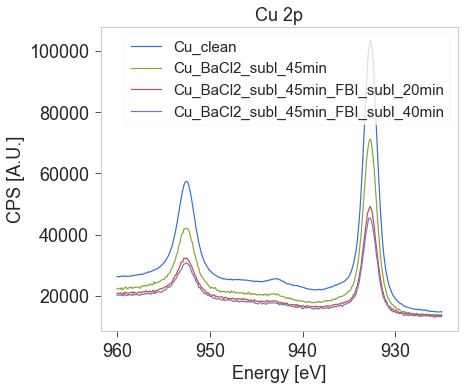

In [18]:
trim_exps = []
# for xp in expsCl2[:3]+expsCl2[4:]:
for xp in expsCl2:
    xp_new = crop_spectrum(xp, region=region, eup=960, edw=925)
    trim_exps.append(xp_new)
    plot_region(xp_new, region)
cosmetics_plot()
plt.title('Cu 2p')

Text(0.5, 1.0, 'Cu 2p')

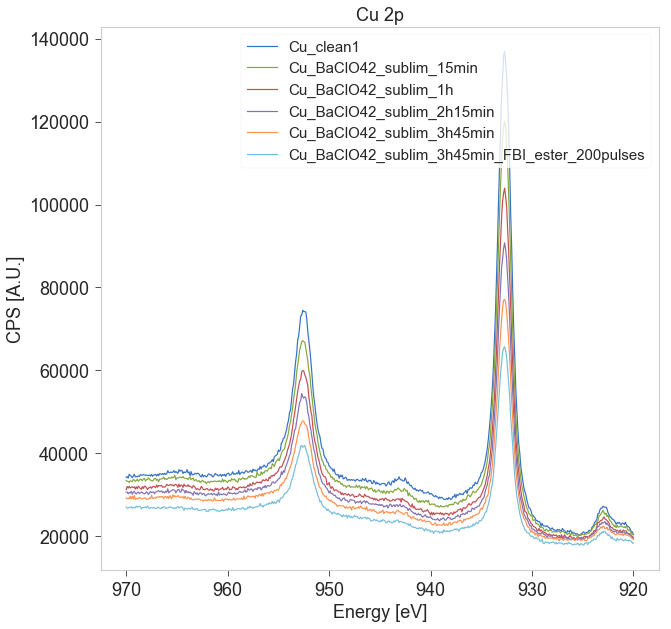

In [28]:
plt.figure(figsize=(10,10))
for xp in expsClO4:
    try:
        plot_region(xp, region)
    except KeyError:
        print('Keyeror on', xp.name)
        
# plt.xlim(70, 100)
# plt.ylim(1.5e5, 4e5)
cosmetics_plot()
plt.title('Cu 2p')

/Users/pabloherrero/sabat/sabatsw/xps/xps_analysis.py:66: RuntimeWarning: invalid value encountered in greater
  dropup = np.where(xp.dfx[region].energy.values > eup)[0]


Text(0.5, 1.0, 'Cu 2p')

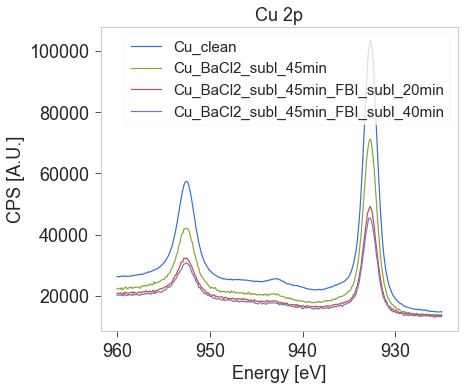

In [18]:
trim_exps = []
# for xp in expsCl2[:3]+expsCl2[4:]:
for xp in expsCl2:
    xp_new = crop_spectrum(xp, region=region, eup=960, edw=925)
    trim_exps.append(xp_new)
    plot_region(xp_new, region)
cosmetics_plot()
plt.title('Cu 2p')

### Subtract double shirley to all Cu regions

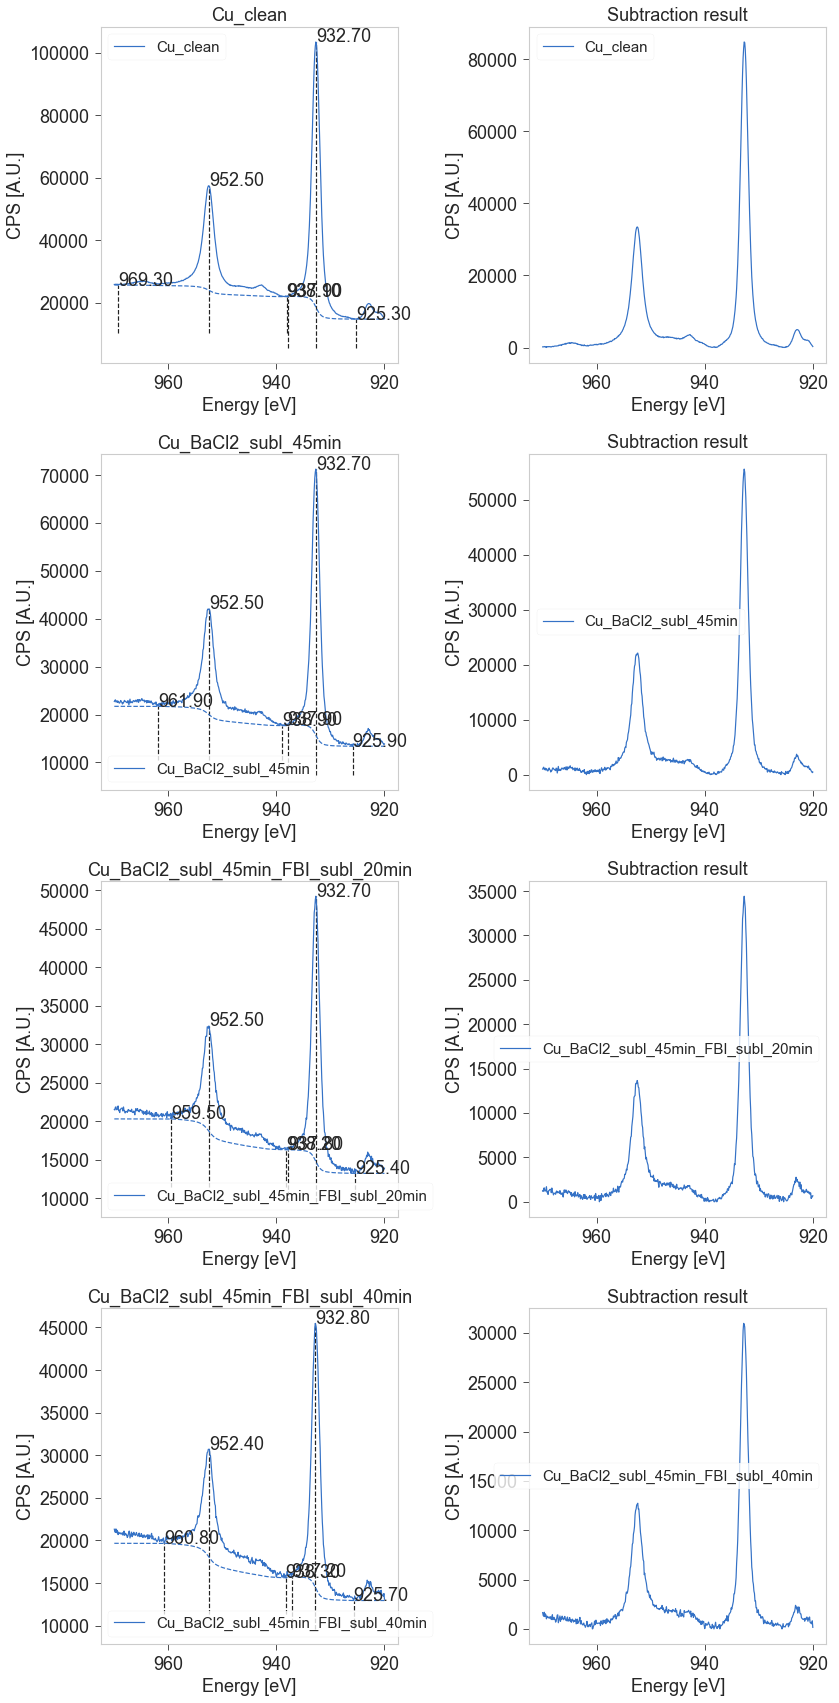

In [31]:
region = 'Cu_2p'

bg_Cl2 = region_2bg_subtract(expsCl2, region=region, xlim=938)

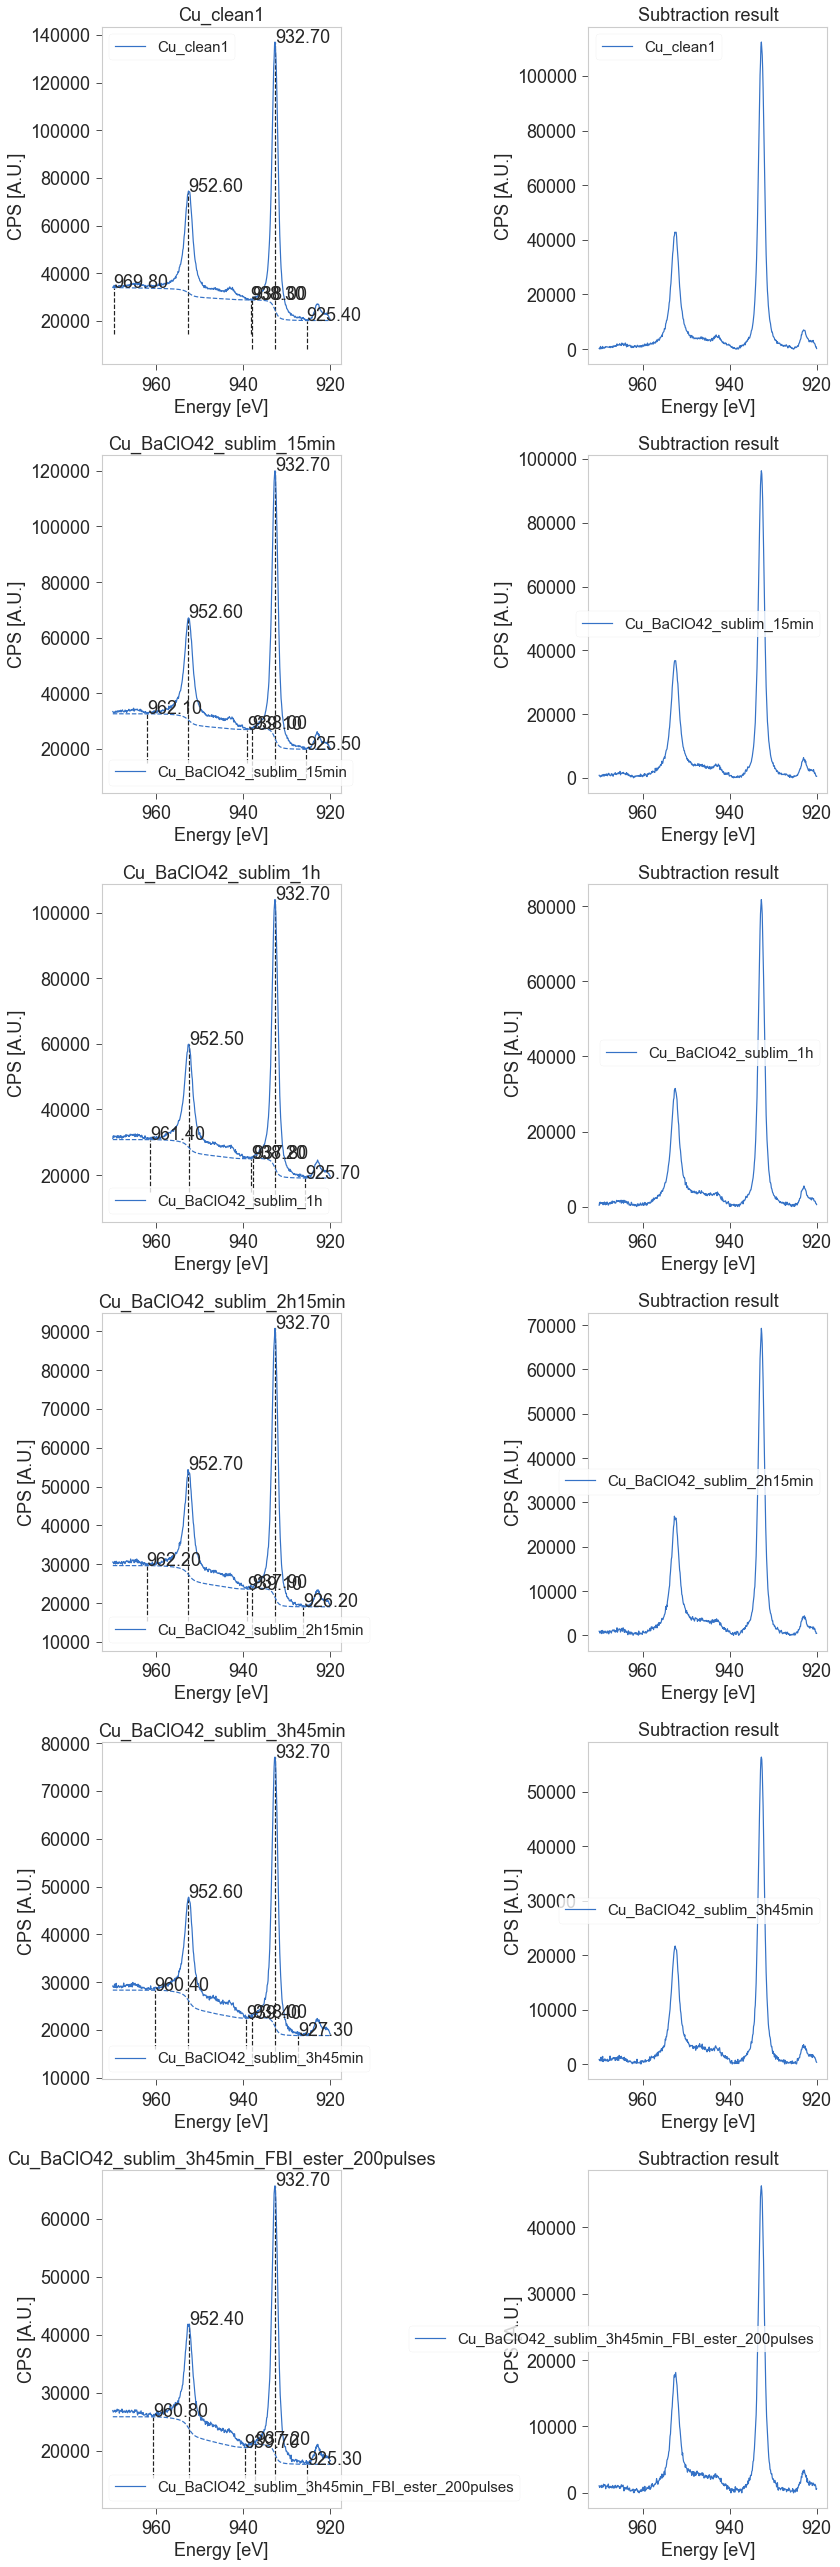

In [32]:
region = 'Cu_2p'

bg_ClO4 = region_2bg_subtract(expsClO4, region=region, xlim=938)

### Bulk subtract background

Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline


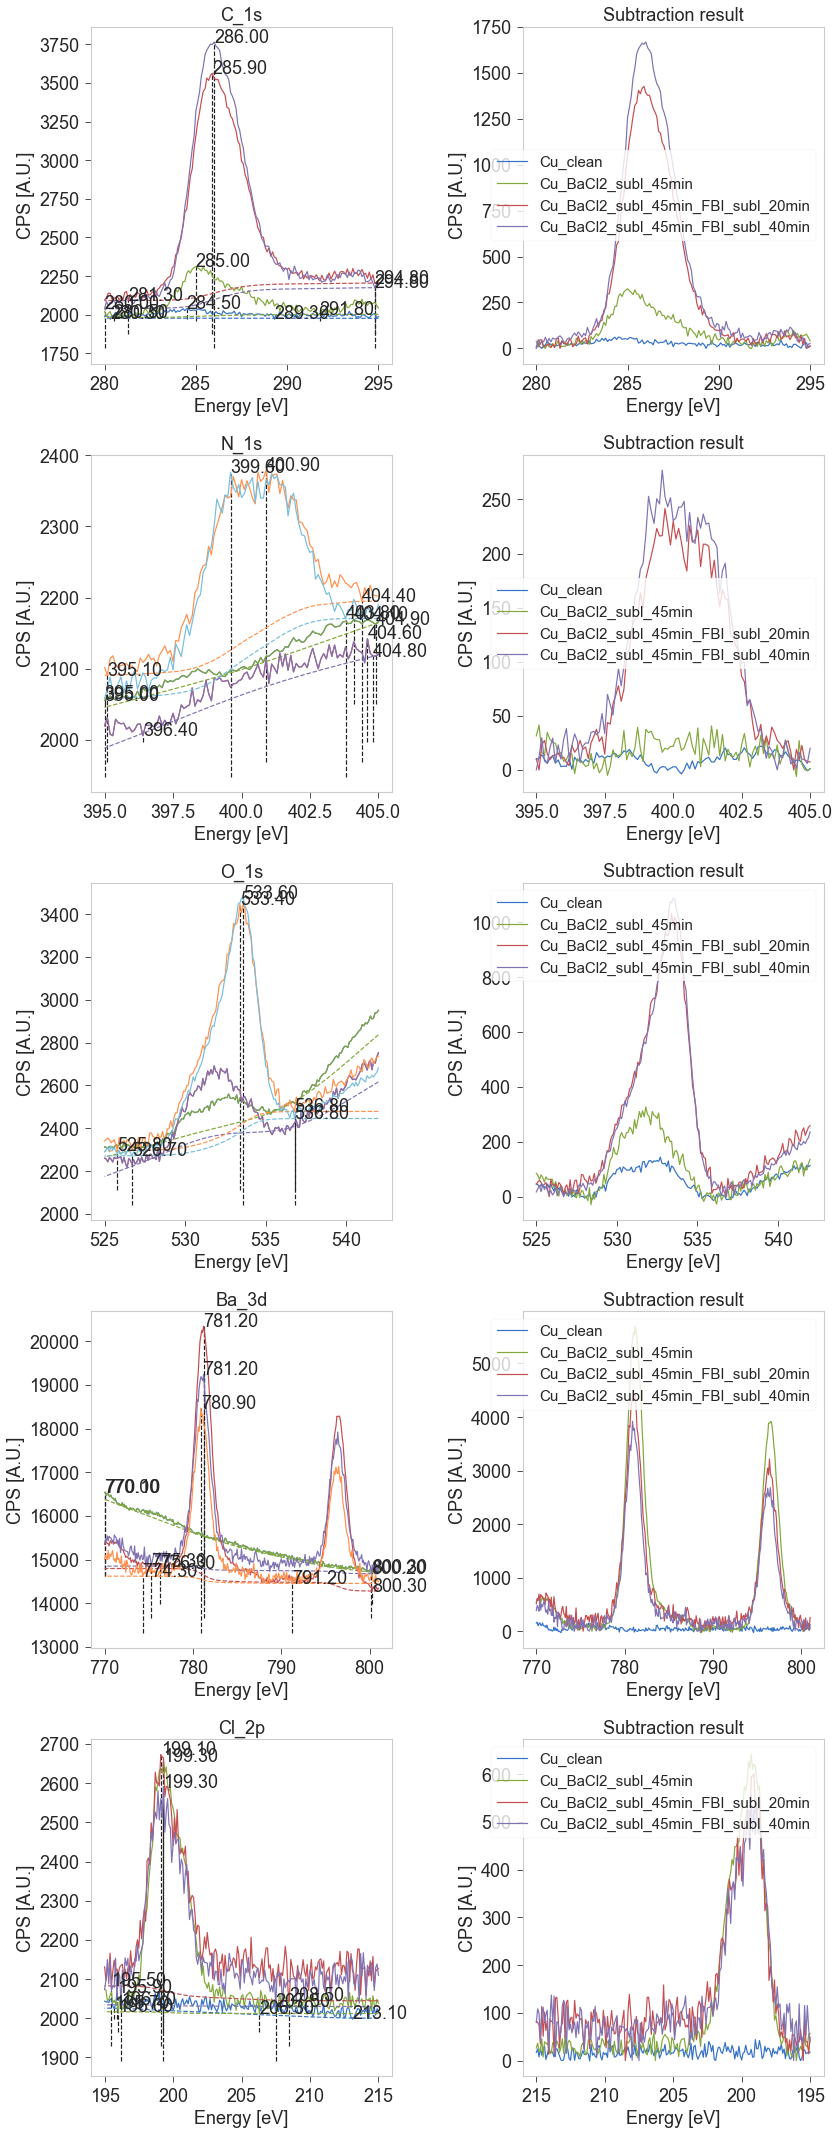

In [33]:
regions = ['C_1s', 'N_1s', 'O_1s', 'Ba_3d', 'Cl_2p']
bg_Cl2 = bulk_bg_subtract(bg_Cl2, regions)

Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline


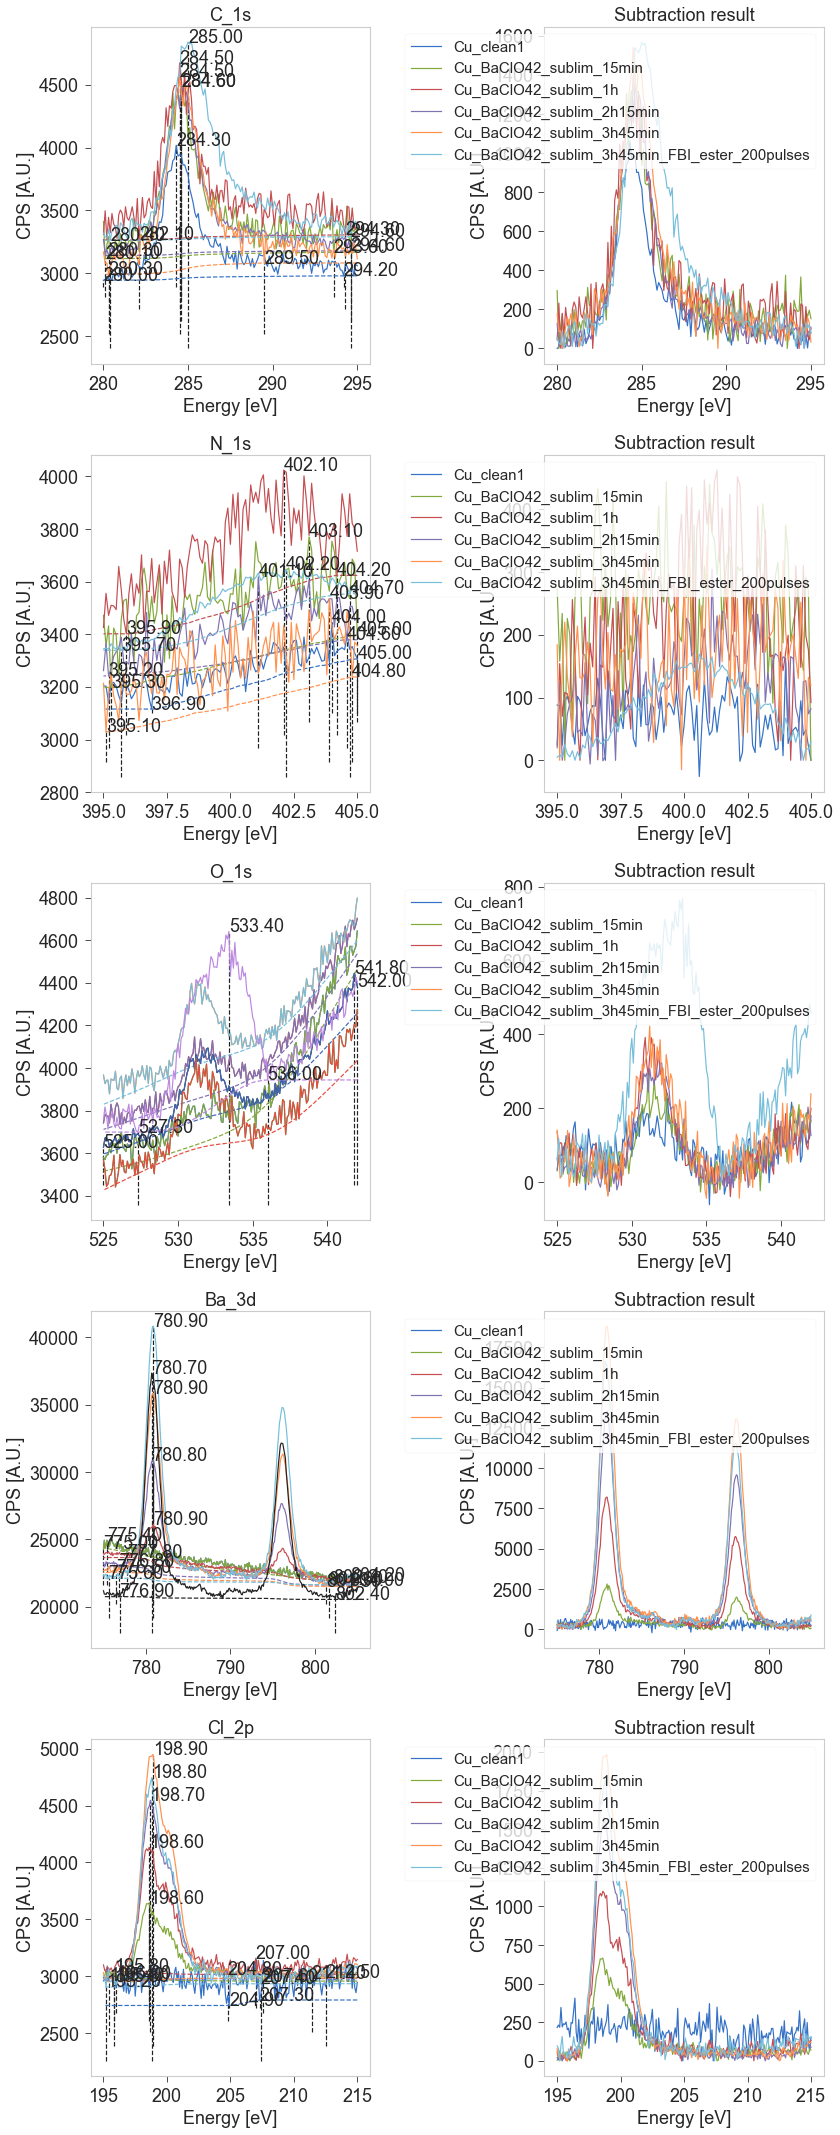

In [34]:
regions = ['C_1s', 'N_1s', 'O_1s', 'Ba_3d', 'Cl_2p']
bg_ClO4 = bulk_bg_subtract(bg_ClO4, regions)

### Fix tailing of all O 1s regions

In [54]:
def fix_tail_bg(xp: XPS_experiment, region: str, eup: float = None, edw: float = None, ax = None, inplace: bool = False):
    """Subtract ALS of the upper or lower tailing of a peak.
       Parameters:
           eup: upper energy limit
           edw: lower energy limit. Specify either one or the other"""
           
    xpf = deepcopy(xp)
    if ax == None: ax = plt.gca()
        
    xpcrop = crop_spectrum(xpf, region, eup=eup, edw=edw)  # Crop the tail to fix bg subtraction
    xpcropBg = subtract_als_bg(xpcrop, region, ax=ax)           # Subtract ALS bg

    dfshort = xpcropBg.dfx[region]                         # Set energy column as index for the whole and the cropped data
    dfshort.set_index('energy', drop=False, inplace=True)
    dfWhole = xpf.dfx[region]
    dfWhole.set_index('energy', drop=False, inplace=True)

    if eup != None:
        dfWhole['counts'].loc[eup:] = dfshort.dropna()['counts'].loc[eup:]   # Update the values of the tail
    elif edw != None:
        dfWhole['counts'].loc[:edw] = dfshort.dropna()['counts'].loc[:edw]   # Update the values of the tail
    else: print('Error: specify upper or lower limit')

    dfWhole.reset_index(drop=True, inplace=True)             # Reset the index and update the dfx in XPS_experiment

    xpf.dfx[region] = dfWhole
    plot_region(xpf, region, ax = ax)
    ax.invert_xaxis()
    
    if inplace:
        xp.dfx[region] = dfWhole
        return xp
    else: return xpf    

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


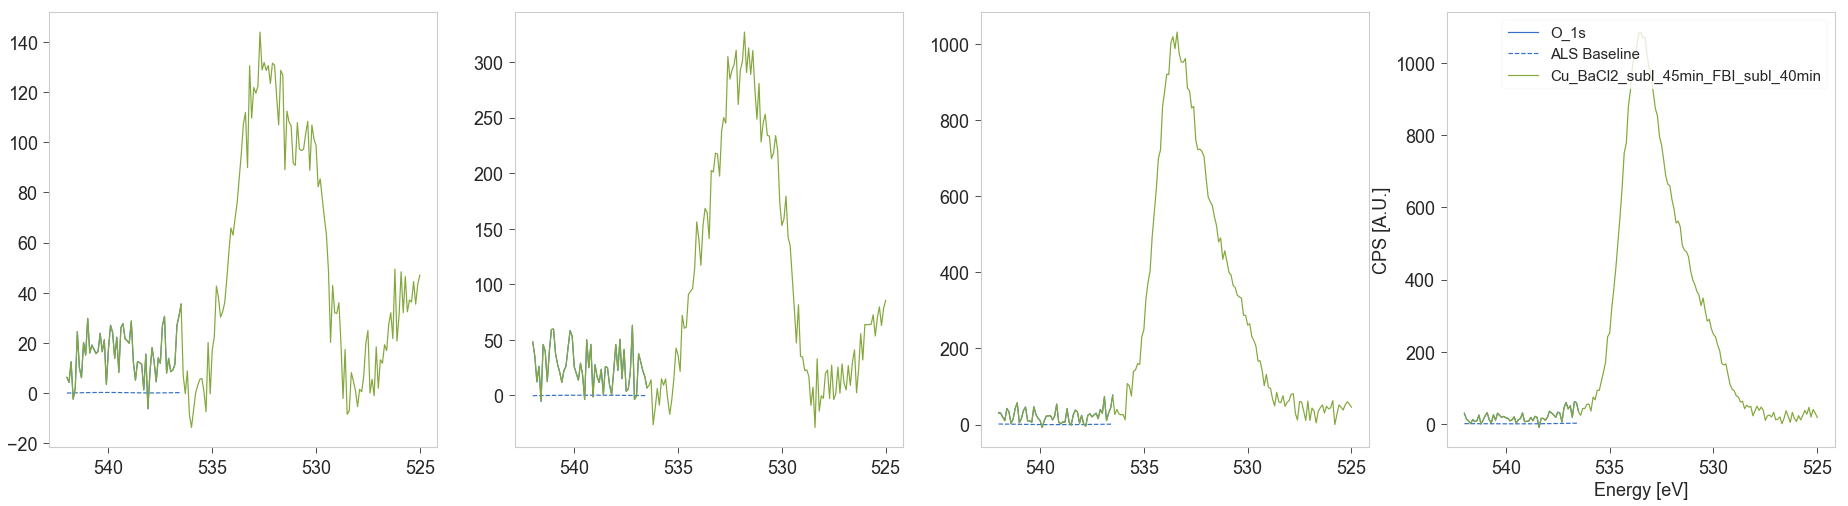

In [55]:
region = 'O_1s'
fig, ax = plt.subplots(1, len(bg_Cl2), figsize=(8*len(bg_Cl2), 8))
for i,xp in enumerate(bg_Cl2):
    xp_bg = fix_tail_bg(xp, region, edw=536.5, ax=ax[i], inplace=True)

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


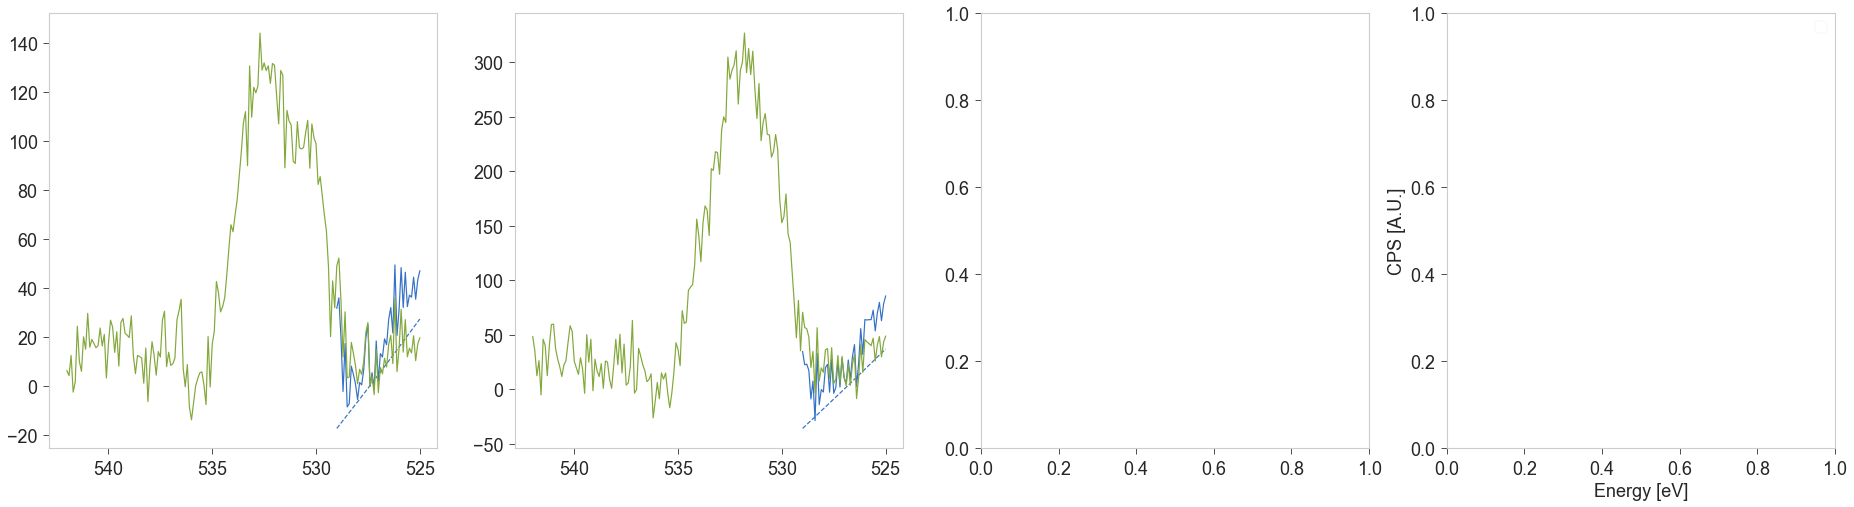

In [56]:
region = 'O_1s'
fig, ax = plt.subplots(1, len(bg_Cl2), figsize=(8*len(bg_Cl2), 8))
for i,xp in enumerate(bg_Cl2[:2]):
    xp_bg = fix_tail_bg(xp, region, eup=529, ax=ax[i], inplace=False)

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


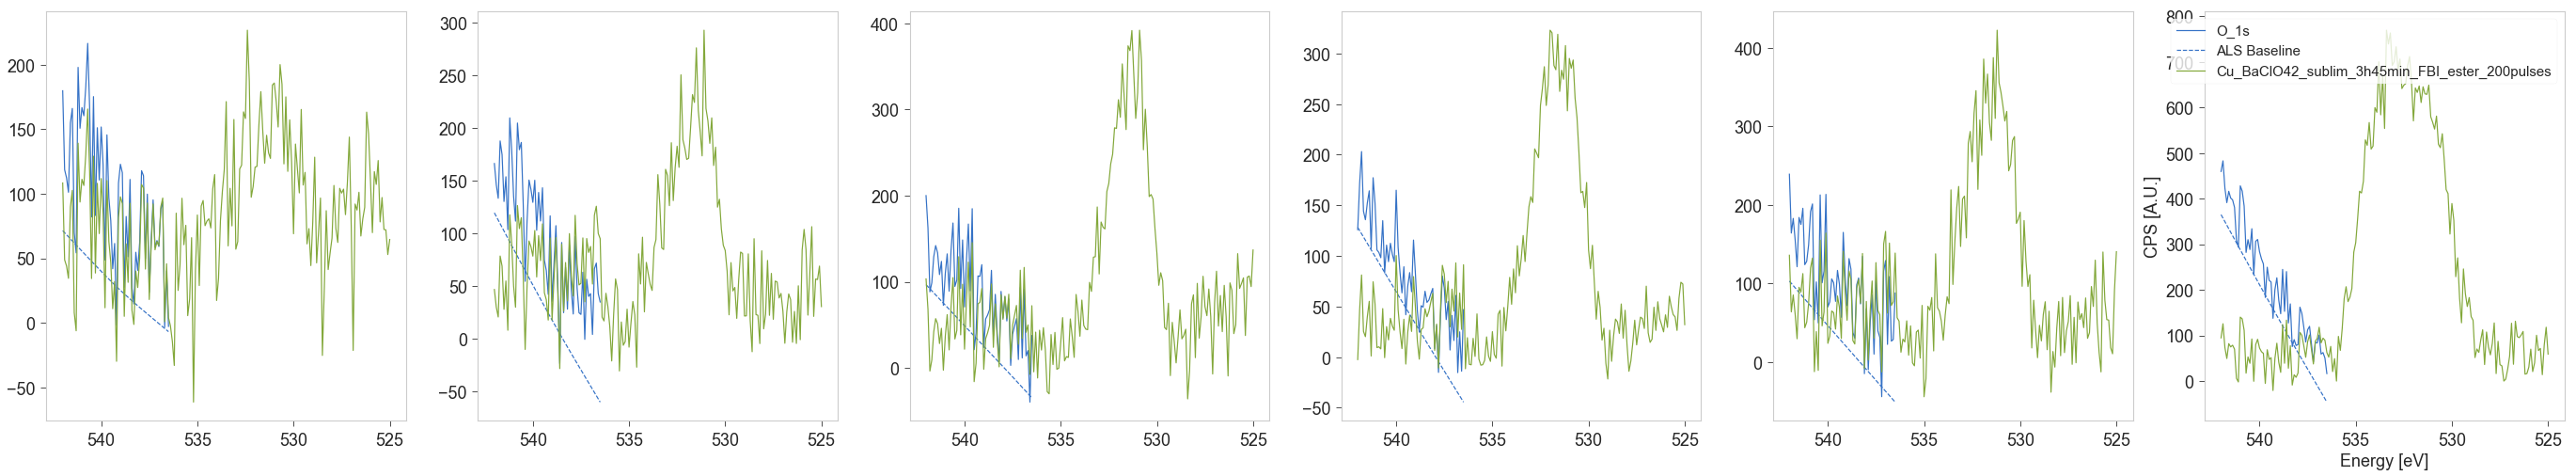

In [58]:
region = 'O_1s'
fig, ax = plt.subplots(1, len(bg_ClO4), figsize=(8*len(bg_ClO4), 8))
for i,xp in enumerate(bg_ClO4):
    xp_bg = fix_tail_bg(xp, region, edw=536.5, ax=ax[i], inplace=True)

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


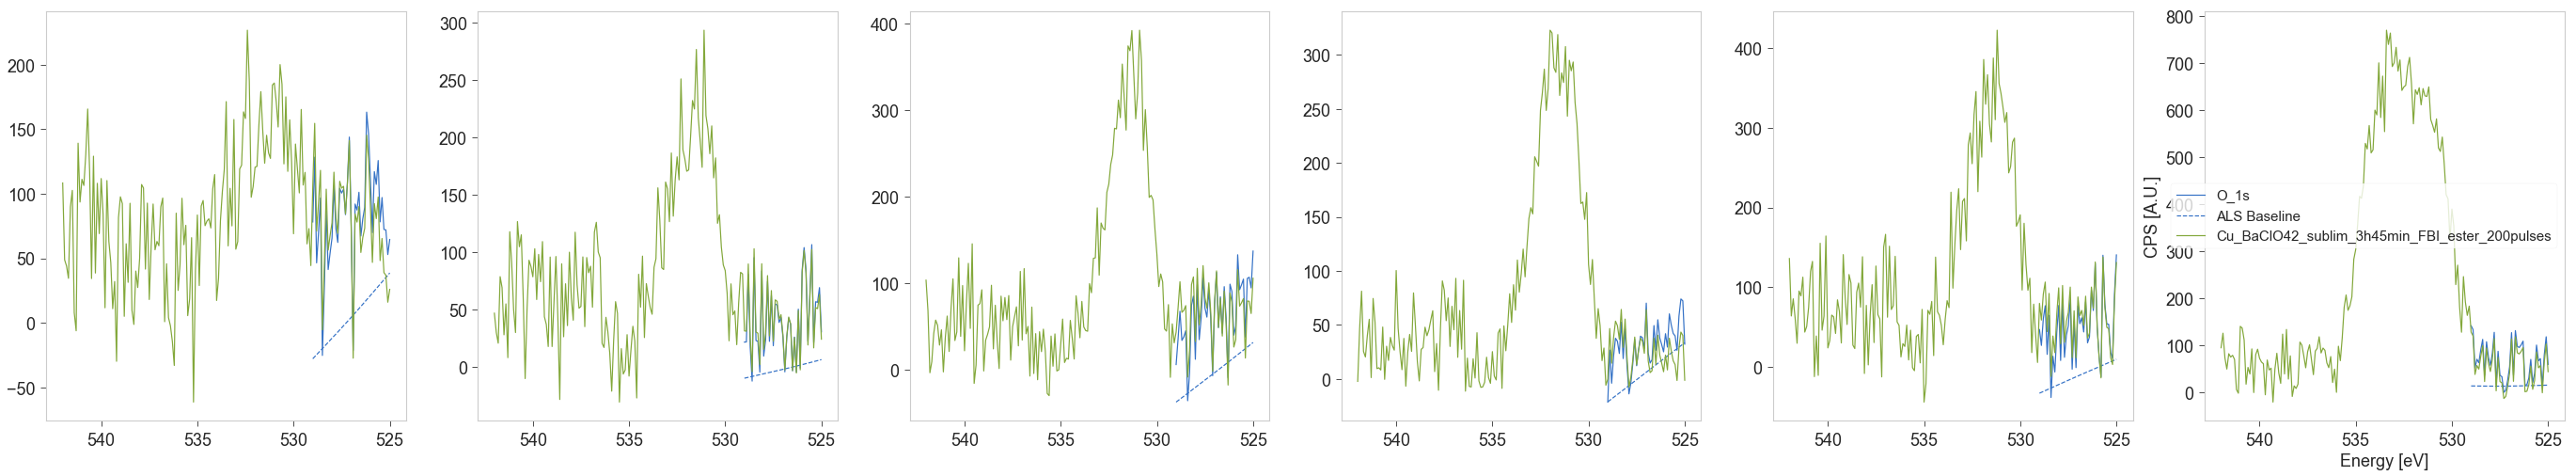

In [59]:
region = 'O_1s'
fig, ax = plt.subplots(1, len(bg_ClO4), figsize=(8*len(bg_ClO4), 8))
for i,xp in enumerate(bg_ClO4):
    xp_bg = fix_tail_bg(xp, region, eup=529, ax=ax[i], inplace=True)

## Compress noisy regions

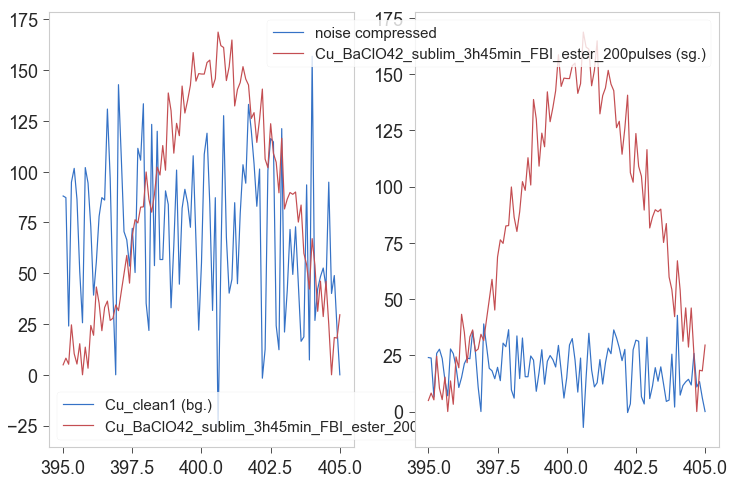

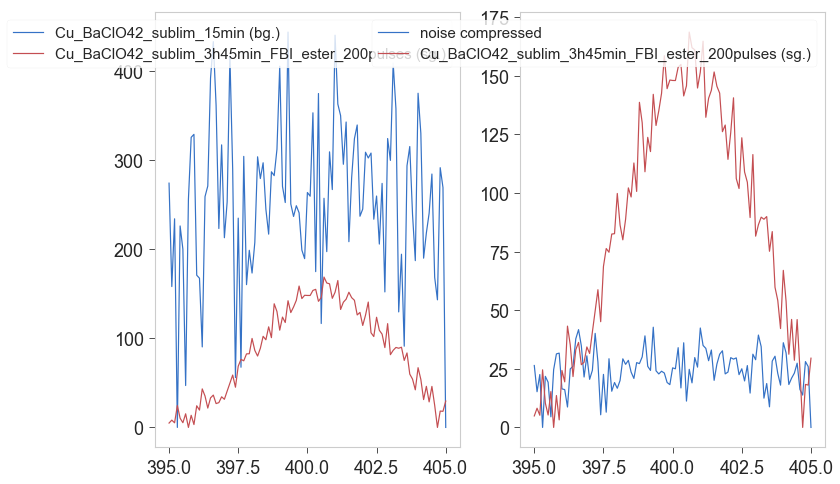

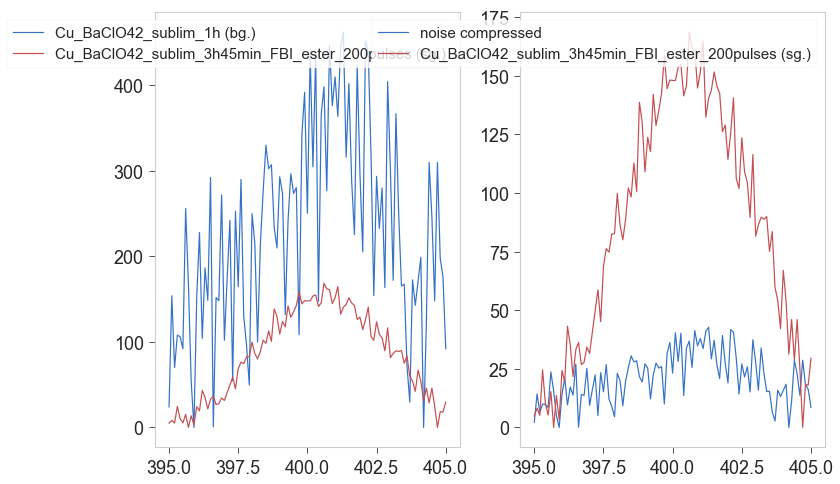

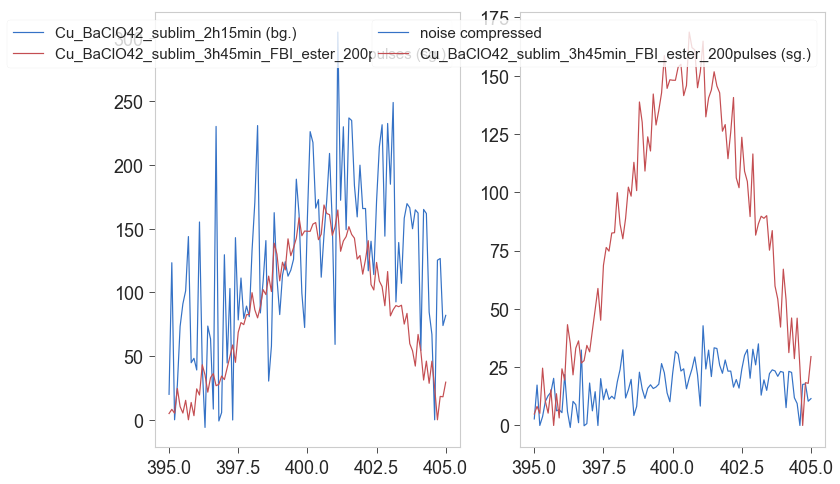

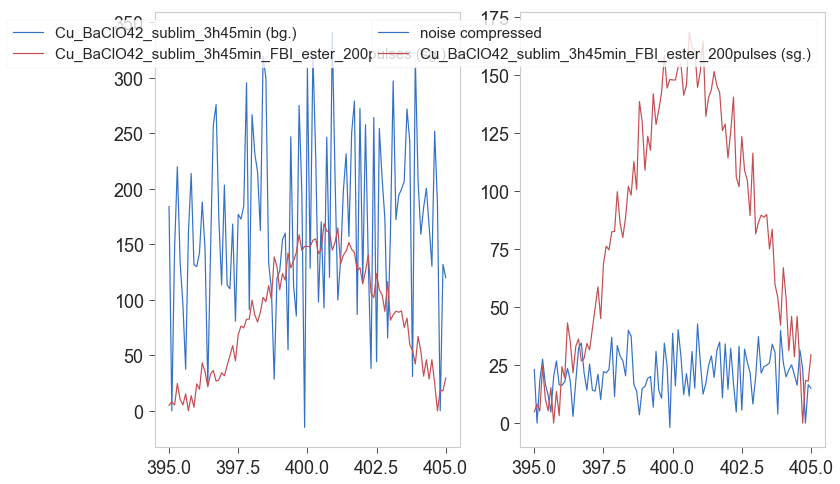

In [65]:
region= 'N_1s'
for xp in bg_ClO4[:-1]:
    compress_noisy_region(xp, xpRef=bg_ClO4[5], region=region, inplace=True);

### Plot result of bulk subtract

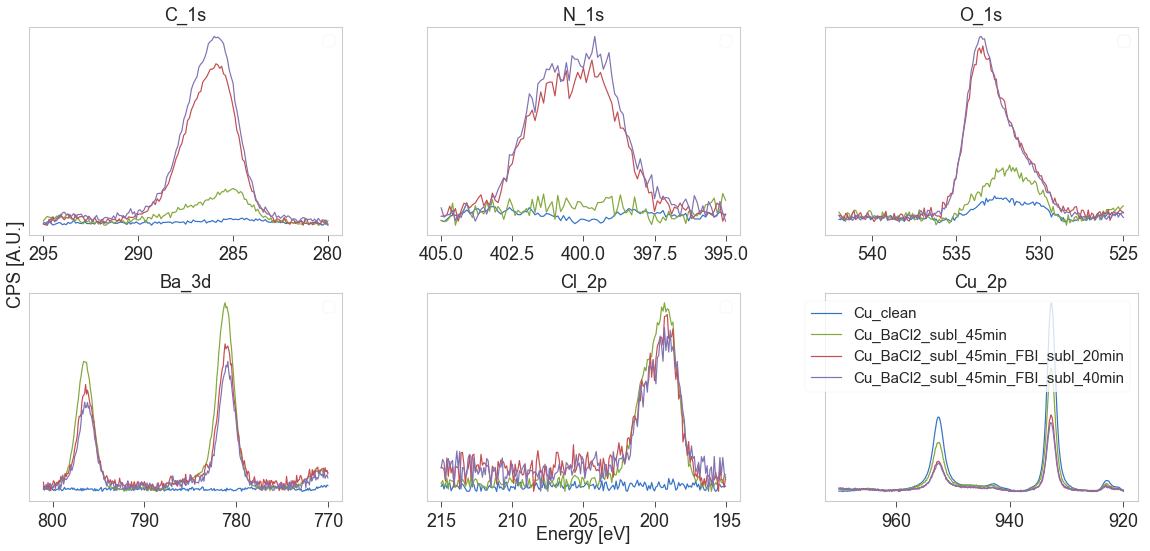

In [63]:
plot_xp_regions(bg_Cl2, regions+['Cu_2p']);

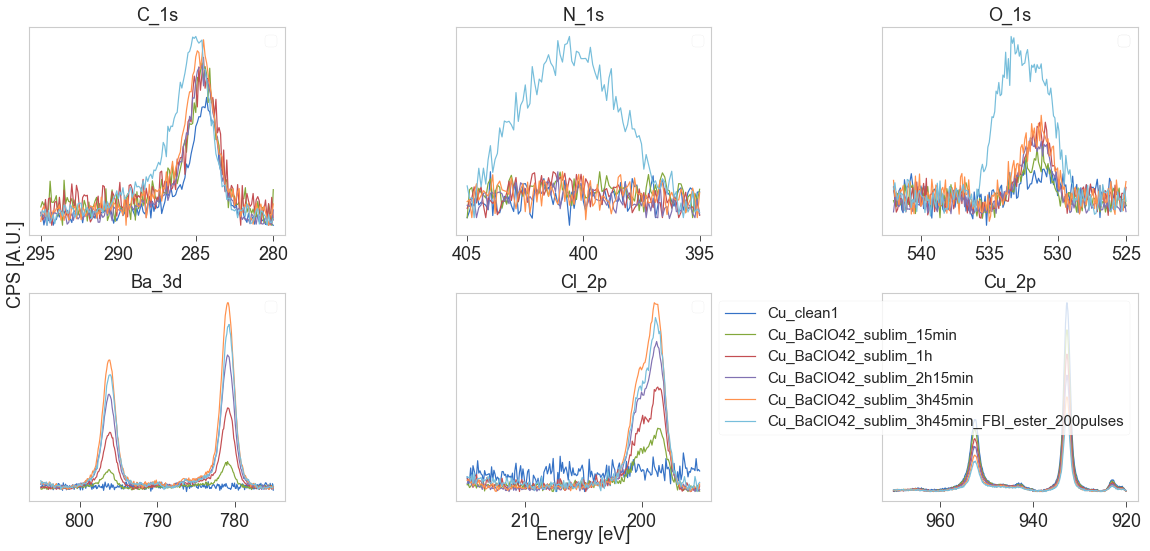

In [66]:
plot_xp_regions(bg_ClO4, regions+['Cu_2p']);

## Scale to Cu 2p

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


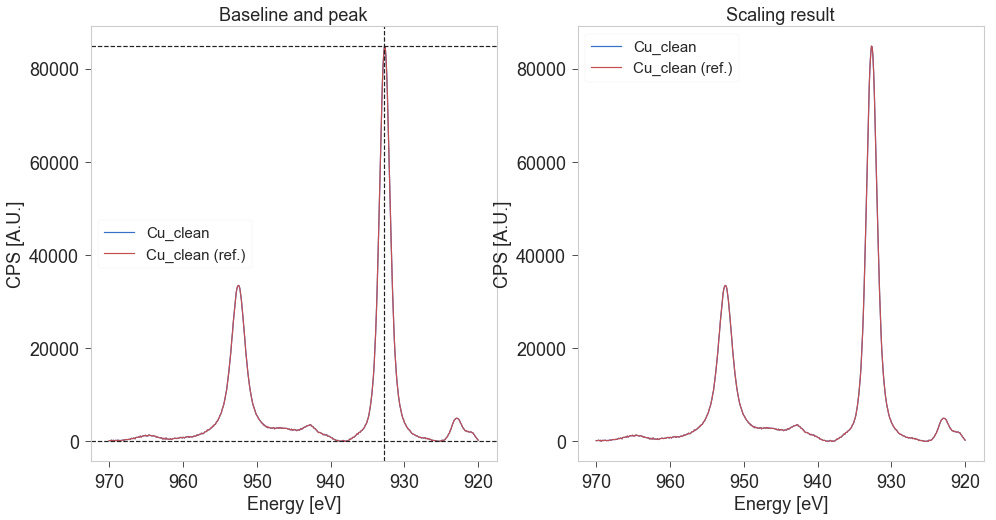

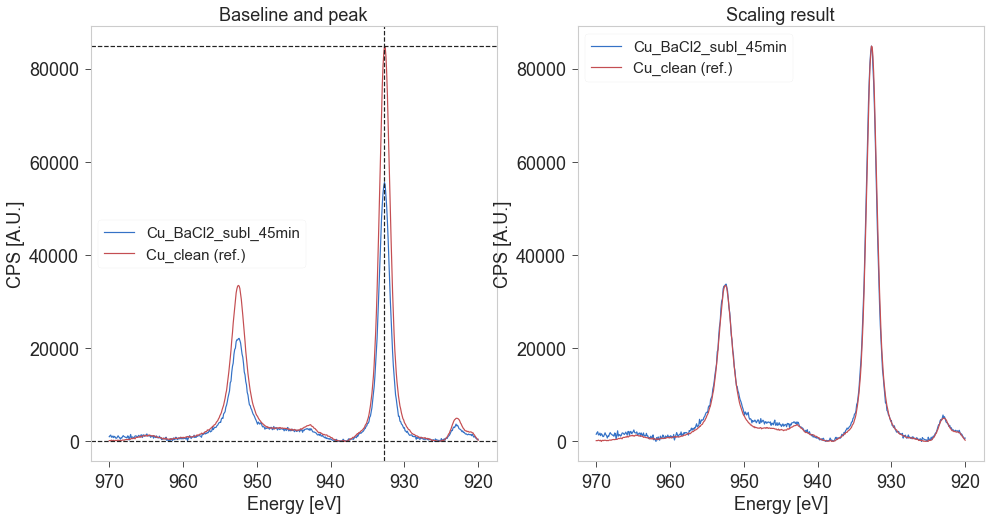

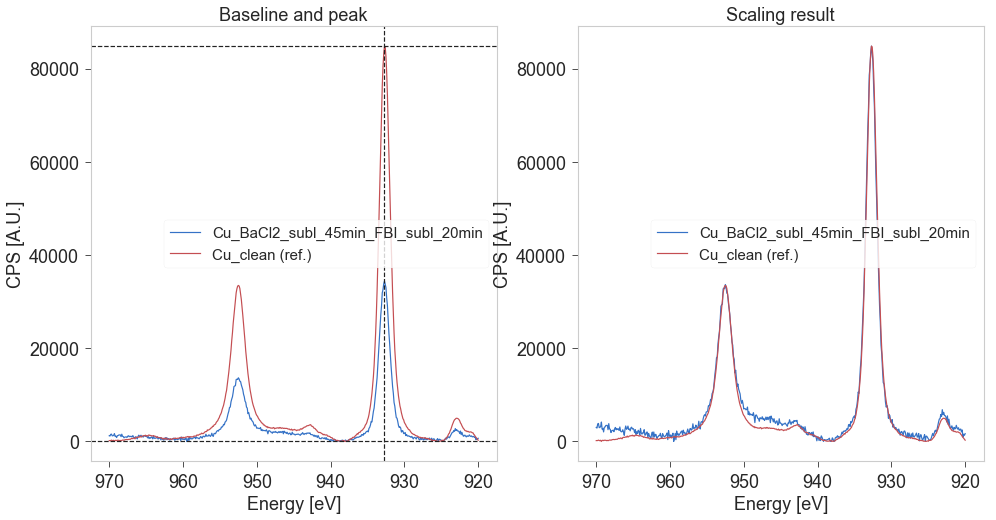

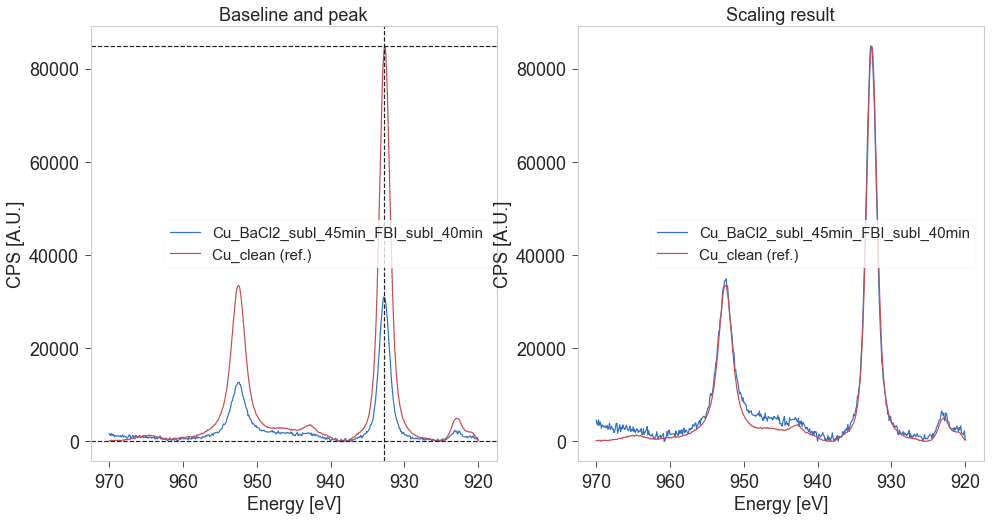

In [67]:
scaled_Cl2 = []
for xpbg in bg_Cl2:
    scale = scale_and_plot_spectra(xp = xpbg, xpRef = bg_Cl2[0], region = 'Cu_2p')
    scaled_Cl2.append(scale_dfx(xp = xpbg, scale_factor = scale))

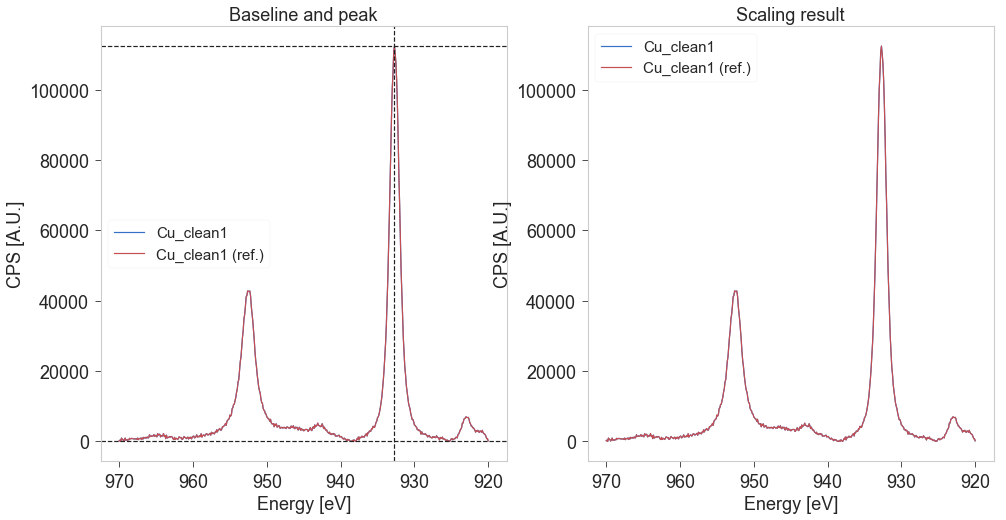

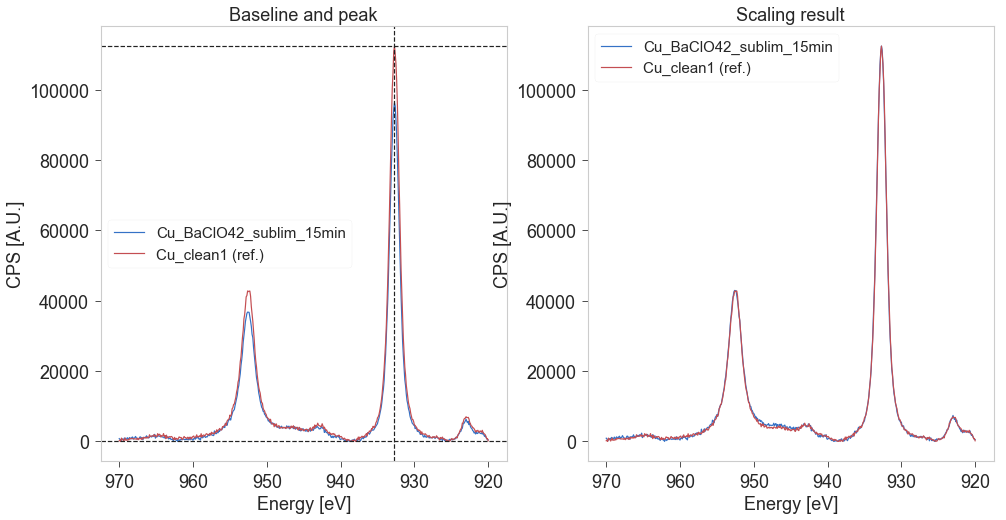

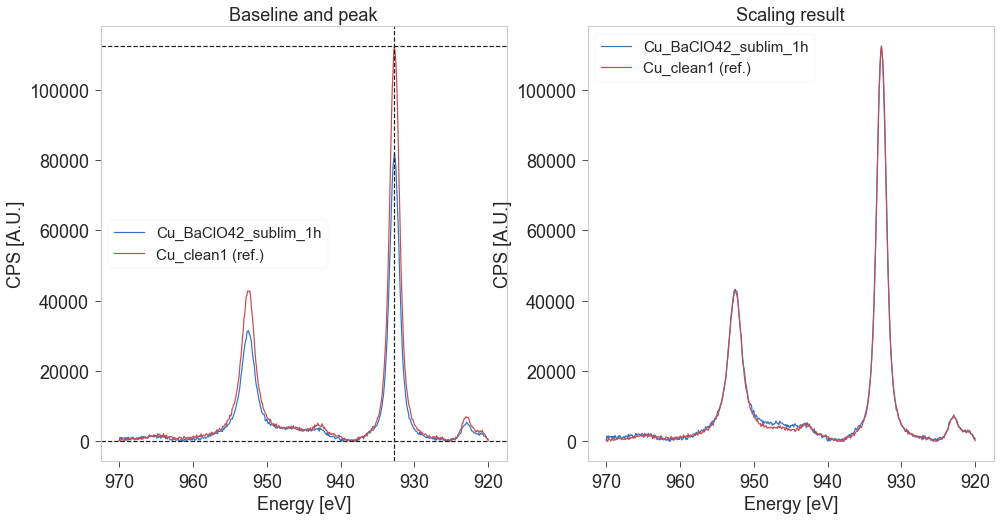

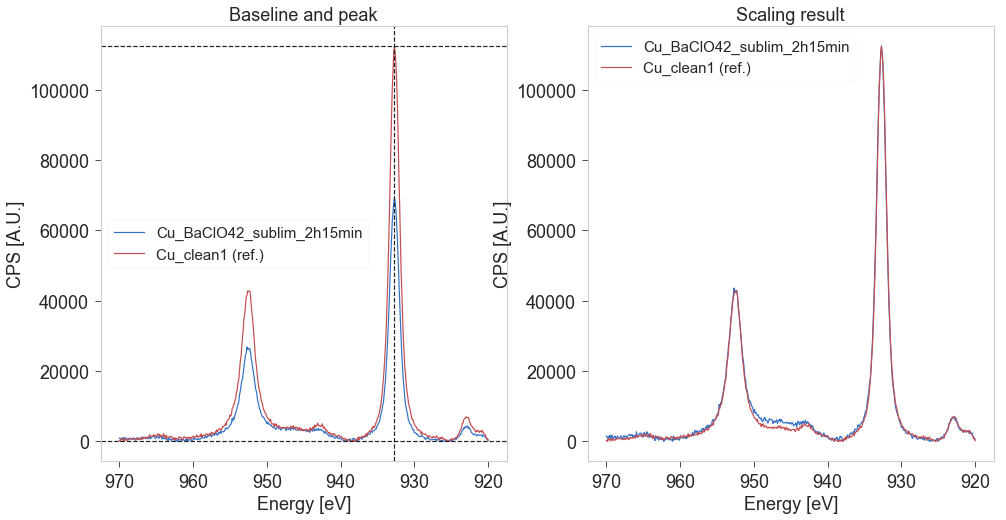

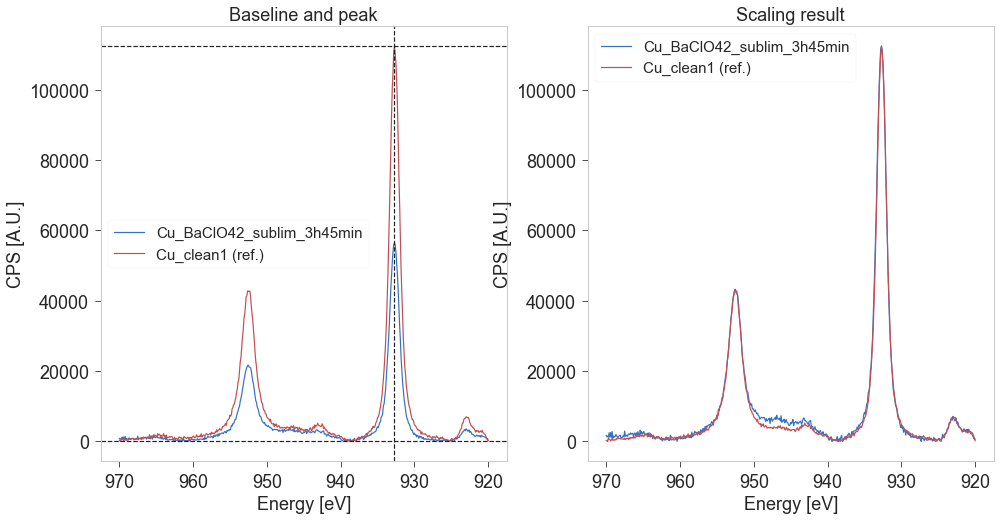

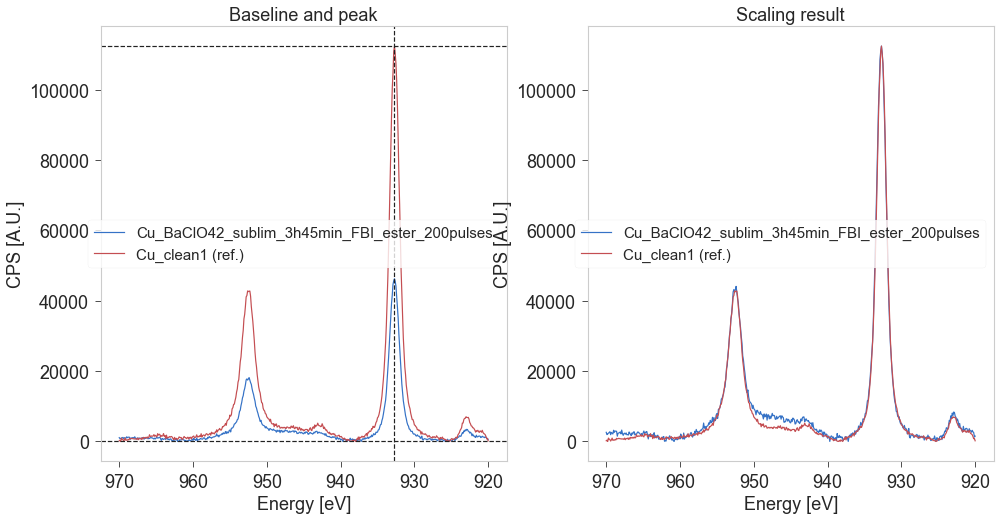

In [68]:
scaled_ClO4 = []
for xpbg in bg_ClO4:
    scale = scale_and_plot_spectra(xp = xpbg, xpRef = bg_ClO4[0], region = 'Cu_2p')
    scaled_ClO4.append(scale_dfx(xp = xpbg, scale_factor = scale))

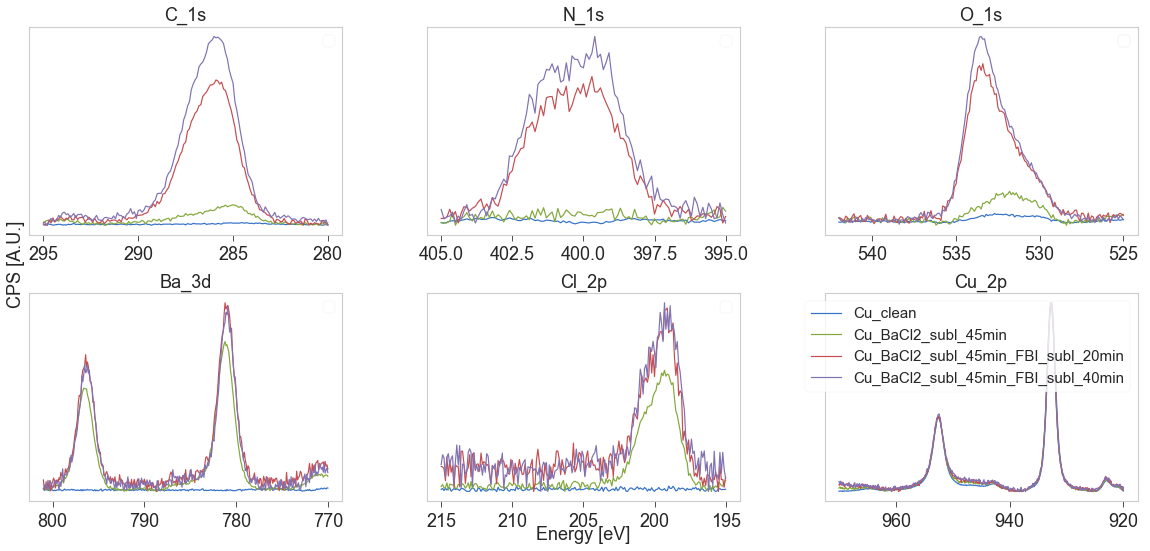

In [69]:
plot_xp_regions(scaled_Cl2, regions+['Cu_2p']);

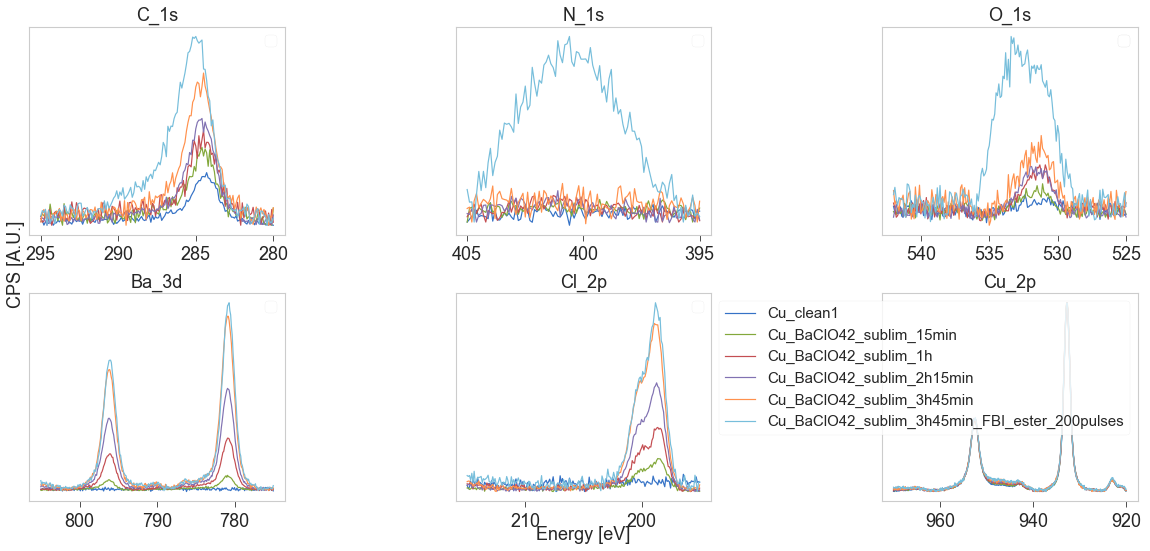

In [70]:
plot_xp_regions(scaled_ClO4, regions+['Cu_2p']);

## Store processed experiments

### Unscaled

In [73]:
for xp in bg_Cl2:
    filepath, filename = os.path.split(xp.path)
    filename = os.path.splitext(filename)[0]
    newpath = filepath + '/proc'
    try:
        os.mkdir(newpath)
    except FileExistsError: pass
#     print(newpath + filename)
    write_processed_xp(newpath + filename + '.uxy', xp)

In [74]:
for xp in bg_ClO4:
    filepath, filename = os.path.split(xp.path)
    filename = os.path.splitext(filename)[0]
    newpath = filepath + '/proc'
    try:
        os.mkdir(newpath)
    except FileExistsError: pass
#     print(newpath + filename)
    write_processed_xp(newpath + filename + '.uxy', xp)

### Scaled

In [72]:
for xp in scaled_Cl2:
    filepath, filename = os.path.split(xp.path)
    filename = os.path.splitext(filename)[0]
    newpath = filepath + '/proc'
    try:
        os.mkdir(newpath)
    except FileExistsError: pass
    write_processed_xp(newpath + filename + '.sxy', xp)

In [75]:
for xp in scaled_ClO4:
    filepath, filename = os.path.split(xp.path)
    filename = os.path.splitext(filename)[0]
    newpath = filepath + '/proc'
    try:
        os.mkdir(newpath)
    except FileExistsError: pass
    write_processed_xp(newpath + filename + '.sxy', xp)